In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from ema_workbench import (Model, Policy, MultiprocessingEvaluator, Samplers)
from ema_workbench.analysis import feature_scoring
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import feature_scoring
from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench import MultiprocessingEvaluator
import os


from ema_workbench import MultiprocessingEvaluator
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress, ArchiveLogger)
from ema_workbench.em_framework.optimization import (EpsNSGAII)
import numpy as np
from ema_workbench.analysis import parcoords



#import
from ema_workbench import Model, MultiprocessingEvaluator, Policy, Scenario

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
import time
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import pairs_plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ema_workbench.analysis import prim
from ema_workbench.em_framework.outcomes import ScalarOutcome
import shutil



from ema_workbench.analysis import feature_scoring

ema_logging.log_to_stderr(ema_logging.INFO)


if __name__ == "__main__":

    # --- Load your model ---
    model, planning_steps = get_model_for_problem_formulation(3)

    ema_logging.log_to_stderr(ema_logging.INFO)


    reference_values = {
        "Bmax": 175,
        "Brate": 1.5,
        "pfail": 0.5,
        "discount rate 0": 3.5,
        "discount rate 1": 3.5,
        "discount rate 2": 3.5,
        "ID flood wave shape": 4,
    }
    scen1 = {}

    for key in model.uncertainties:
        name_split = key.name.split("_")

        if len(name_split) == 1:
            scen1.update({key.name: reference_values[key.name]})

        else:
            scen1.update({key.name: reference_values[name_split[1]]})

    ref_scenario = Scenario("reference", **scen1)

#     convergence_metrics = [
#     EpsilonProgress()
# ]
    if os.path.isdir("archives/tmp"):
        shutil.rmtree("archives/tmp")

    convergence_metrics = [
    ArchiveLogger(
        "./archives",
        [l.name for l in model.levers],
        [o.name for o in model.outcomes],
        base_filename="MORDM.tar.gz"    ),
    EpsilonProgress(),
]


    espilon = [0.01] * len(model.outcomes)


    nfe = 5e3  # proof of principle only, way to low for actual use



    with MultiprocessingEvaluator(model ) as evaluator:
        results, convergence = evaluator.optimize(
            nfe=nfe,
            searchover="levers",
            epsilons=espilon,
            convergence=convergence_metrics,
            reference=ref_scenario,
        )


    data = results.loc[:, [o.name for o in model.outcomes]]
    limits = parcoords.get_limits(data)




[MainProcess/INFO] pool started with 8 workers
100%|█████████████████████████████████████▉| 4990/5000 [04:25<00:00, 18.64it/s]INFO | EpsNSGAII finished; Total NFE: 5090, Elapsed Time: 0:04:30.978759
5090it [04:30, 18.78it/s]                                                      
[MainProcess/INFO] optimization completed, found 15 solutions
[MainProcess/INFO] terminating pool


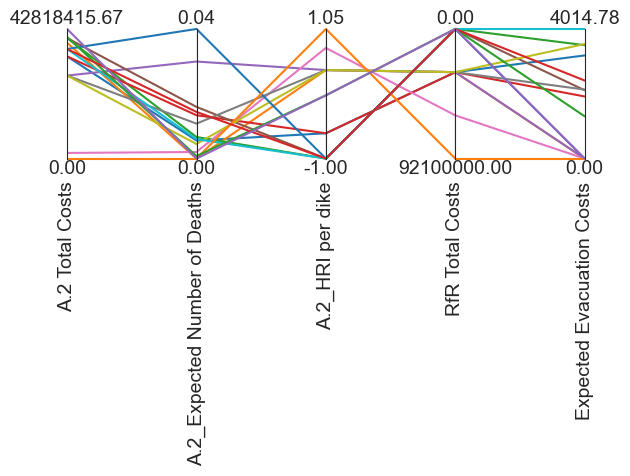

<Figure size 1400x1000 with 0 Axes>

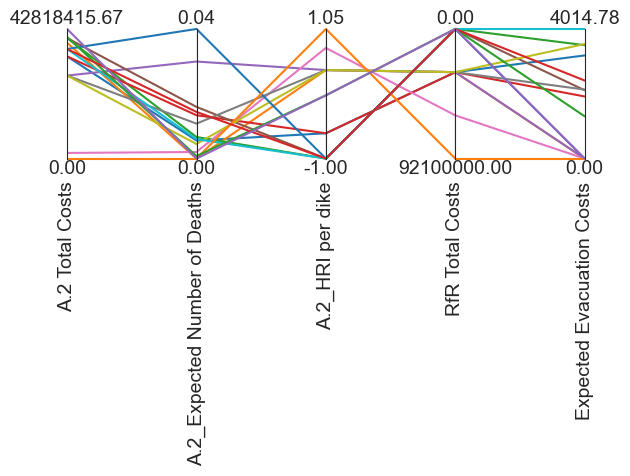

In [5]:


paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("RfR Total Costs")
    # Set larger figure size (wider and taller)
plt.figure(figsize=(14, 10))  # width=12 inches, height=8 inches

# Generate parallel axes with your limits
paraxes = parcoords.ParallelAxes(limits)

# Plot the data
paraxes.plot(data)

# Invert specific axis
paraxes.invert_axis("RfR Total Costs")

# Save the plot
plt.savefig("mordm_parallel_coordinates.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [6]:
archives = ArchiveLogger.load_archives("./archives/MORDM.tar.gz")


In [11]:
#Create policy dataframe
lever_names = [l.name for l in model.levers]
policies_df = results[lever_names]
policies_df.to_csv("candidate_policies.csv", index=False)


In [10]:
#Add policies to dictionary and to Policy of ema workbench
policy_dicts = policies_df.to_dict('records')
policies = [
    Policy(f"policy_{i}", **d)
    for i, d in enumerate(policy_dicts)
]

In [7]:
from ema_workbench import HypervolumeMetric
from ema_workbench.em_framework.optimization import to_problem

reference_set = results
problem = to_problem(model, searchover="levers")

hv = HypervolumeMetric(reference_set, problem)

hypervolume = [(nfe, hv.calculate(archives)) for nfe, archives in archives.items()]
hypervolume.sort(key=lambda x:x[0])
hypervolume = np.asarray(hypervolume)

EMAError: Parameter names ['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2'] not found in archive

In [8]:
print(results)

    0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0         0        0        0        0        0        0        1        0   
1         0        0        0        0        0        0        1        0   
2         0        0        0        0        0        0        0        0   
3         0        0        0        0        0        0        1        0   
4         0        0        0        0        0        0        1        0   
5         0        0        0        0        0        0        0        0   
6         0        0        0        0        0        0        1        1   
7         0        0        0        0        0        0        1        0   
8         0        0        0        0        0        0        1        0   
9         0        0        0        0        0        0        0        0   
10        0        0        0        0        0        0        0        0   
11        0        0        0        0        0        0        

In [29]:
policies = results
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,0,0,0,0,0,0,0,0,0,...,0,4,1,6,4,0,2,6,6,6
1,0,0,0,0,0,0,0,0,0,0,...,0,3,2,1,4,4,5,2,6,4
2,0,0,0,0,0,0,0,0,0,0,...,0,5,6,1,4,4,5,2,0,1
3,0,0,0,0,0,0,1,0,0,0,...,0,5,5,6,3,3,2,3,6,5
4,0,0,0,0,0,0,0,0,0,0,...,0,4,4,6,4,4,2,2,6,5
5,0,0,0,0,0,0,1,1,0,0,...,0,4,2,6,4,1,6,4,1,5
6,0,0,0,0,0,0,1,1,0,0,...,0,5,2,1,0,1,6,4,6,2
7,0,0,0,0,0,0,1,1,0,0,...,0,1,0,6,4,6,6,5,1,2
8,0,0,0,0,0,0,1,1,0,0,...,0,4,5,5,4,1,5,7,6,2
9,0,0,0,0,0,0,1,0,0,0,...,0,5,4,6,1,5,5,6,6,10


In [1]:
#Voor overplaatsen naar PRIM
lever_names = [l.name for l in model.levers]
policies_df = results[lever_names]

NameError: name 'model' is not defined

In [30]:
from ema_workbench import Policy

policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [31]:

n_scenarios = 10
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started with 8 workers
100%|████████████████████████████████████████| 170/170 [00:26<00:00,  6.51it/s]
[MainProcess/INFO] terminating pool


In [32]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    if std==0:
        std = 1

    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std


In [33]:
from ema_workbench import ScalarOutcome

experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
0,2.285788e+16,4.832508e-04,1.020000e+00,1.033800e+09,4.134536e+06
1,5.625038e+16,4.036807e-04,1.614812e+00,8.916000e+08,1.488883e+08
10,3.631385e+16,1.114741e-03,1.933333e+00,8.377000e+08,1.014916e+07
11,2.187923e+16,1.974102e-03,9.900000e-01,6.752000e+08,0.000000e+00
12,1.724110e+16,2.905430e-05,4.728780e+15,9.606000e+08,1.247244e+07
13,2.070407e+16,2.814925e-03,3.133333e+00,8.640000e+08,0.000000e+00
14,3.006654e+16,2.467319e-03,1.010000e+00,7.567000e+08,0.000000e+00
15,2.757740e+08,0.000000e+00,4.638708e+15,6.601000e+08,1.498306e+06
16,2.374784e+16,2.842707e-05,9.700000e-01,6.369000e+08,1.638898e+07
17,2.102101e+15,7.166769e-06,9.007199e+15,3.070000e+07,0.000000e+00


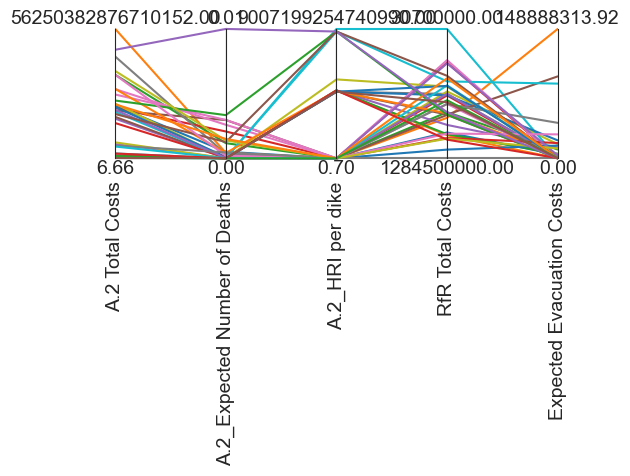

In [34]:
data = scores
limits = parcoords.get_limits(data)


paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("RfR Total Costs")

plt.show()

In [35]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [36]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']

    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')

    # flatten the resulting hierarchical index resulting from
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)

    # we need to control the broadcasting.
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

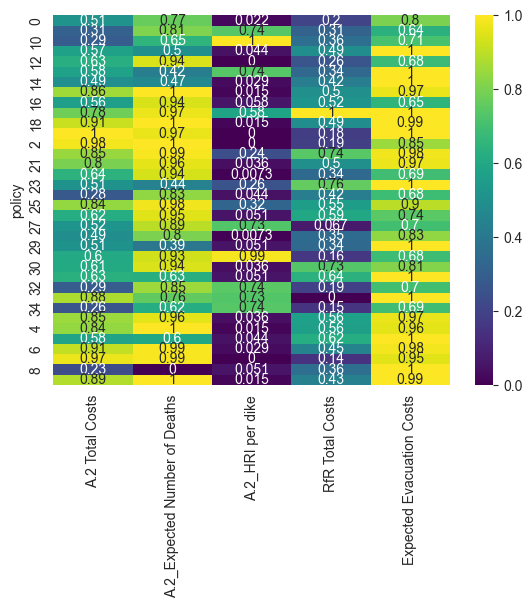

In [37]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

In [38]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

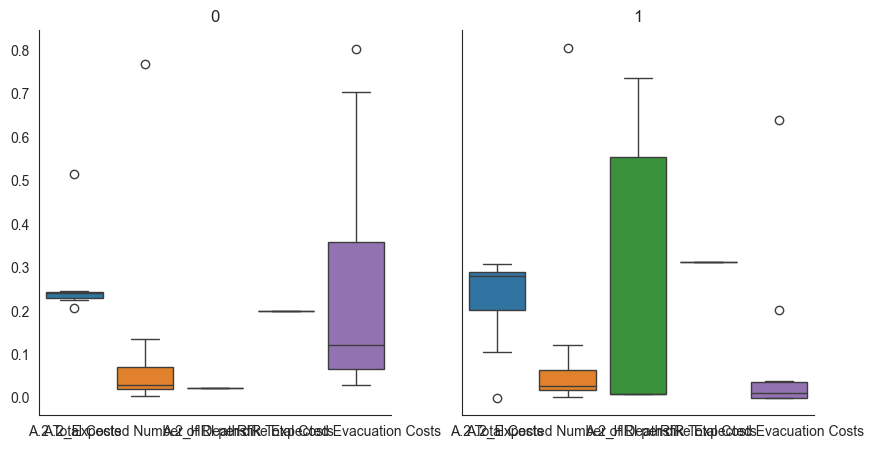

In [39]:
# this generates a 2 plots with a shared y and x axis
fig, axes = plt.subplots(ncols=2, figsize=(10,5),
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this.


# zip allows us to zip together the list of axes and the list of
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)

    # removes top and left hand black outline of axes
    sns.despine()

    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
plt.show()